In [1]:
import numpy as np
import matplotlib.pyplot as plt

import igraph as ig

from scipy.fft import fft2
from scipy.linalg import eigh, norm

from tqdm import tqdm

# Functions

With this function, we display the graph.

In [431]:
def mat_to_graph(mat: np.ndarray):
    
    N = int(np.sqrt(np.shape(mat)[0]//2))
    x, y = np.meshgrid(np.arange(0,N,1),np.arange(0,N,1))
    vertex = []
    for i in range(N):
        for j in range(N):
            vertex.append((x[i,i],-y[j,j]))
    for i in range(N):
        for j in range(N):
            vertex.append((x[i,i]+0.5,-y[j,j]-0.5))
    
    g = ig.Graph.Weighted_Adjacency(mat, mode="undirected", attr="weight")
    nodes = np.arange(g.vcount())
    colors = np.where(nodes<N**2, "orange", "green")
    vlabel = np.where(nodes<N**2, "a", "b")
    my_layout = ig.Layout(vertex)
    g.es["color"] = ["red" if w == 1 else "blue" if w == -1 else "black" for w in g.es["weight"]]
    return ig.plot(g,bbox=(500, 500), layout=my_layout, 
                   vertex_label=nodes, vertex_color=colors ,edge_width=1.5)

Hamiltonian under Open Boundary Conditions (OBCs): first way to terminate the edges.

In [297]:
def HamOBC(N,J=1):
    dk = 2*np.pi/(N+2)
    k = np.linspace(-np.pi,np.pi-dk,N+2) - np.pi
    kx, ky = np.meshgrid(k,k)

    A = np.diag(J*np.ravel(2 - 2*np.cos(ky)))
    C = np.diag(J*np.ravel(2 - 2*np.cos(kx)))
    B = -np.diag(J*(1 - np.ravel(np.exp(-1.j*kx))) * (1 - np.ravel(np.exp(-1.j*ky))))
    A2 = np.roll(fft2(A/(N+2)**2)[::-1],1,axis=0)
    C2 = np.roll(fft2(C/(N+2)**2)[::-1],1,axis=0)
    B2 = np.roll(fft2(B/(N+2)**2)[::-1],1,axis=0)
    
    mask = np.ones(((N+2)**2,(N+2)**2),dtype="bool")
    mask[:N+2,:] = mask[(N+2)*(N+1):,:] = False
    mask[:,:N+2] = mask[:,(N+2)*(N+1):] = False
    mask[::N+2,:] = mask[:,::N+2] = False
    mask[N+1::N+2,:] = mask[:,N+1::N+2] = False
    
    A2 = A2[mask].reshape(N**2,N**2)
    B2 = B2[mask].reshape(N**2,N**2)
    C2 = C2[mask].reshape(N**2,N**2)
    
    H = np.block([
        [A2,B2],
        [np.transpose(np.conjugate(B2)),C2]
    ])

    H = np.round(H,0)
    
    return np.real(H)

Hamiltonian under Open Boundary Conditions (OBCs): second way to terminate the edges.

In [300]:
def HamOBC2(N,J=1):
    
    H = HamOBC(N)
    H[:N,:] = H[:,:N] = 0
    H[N**2 + N-1::N,:] = H[:,N**2 + N-1::N] = 0
    
    return H

Hamiltonian under Open Boundary Conditions (OBCs): third way to terminate the edges.

In [299]:
def HamOBC3(N,J=1):
    
    H = HamOBC(N)
    H[:N**2:N,:] = H[:,:N**2:N] = 0
    H[N*(2*N-1):,:] = H[:,N*(2*N-1):] = 0
    
    return H

# Graphical representation of the hamiltonian

## First way to terminate the edges

In [133]:
N = 4
mat = HamOBC(N)

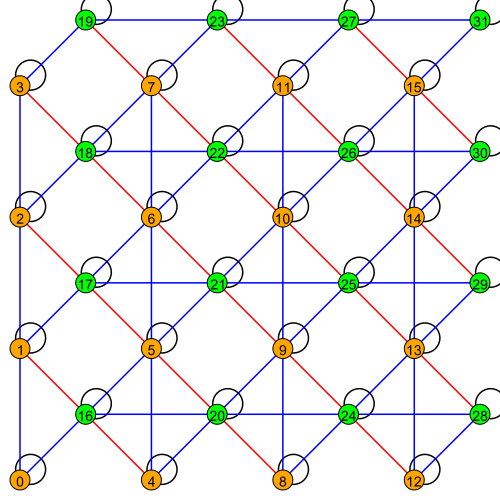

In [86]:
mat_to_graph(mat)

## Second way to terminate the edges

In [429]:
N=4
mat = HamOBC2(N)

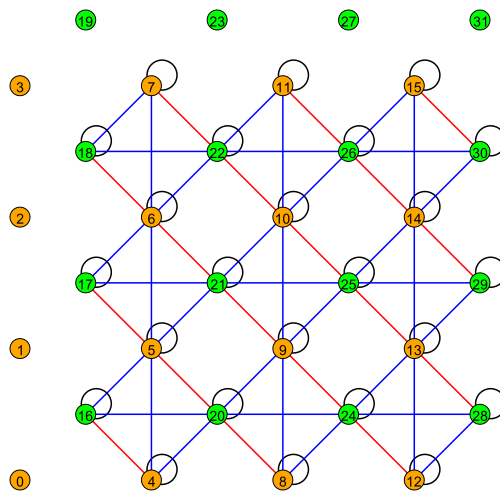

In [430]:
mat_to_graph(mat)

## Third way to terminate the edges

In [425]:
N = 4
mat = HamOBC3(N)

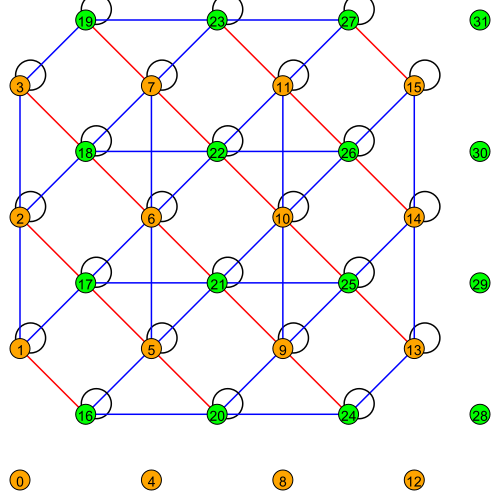

In [379]:
mat_to_graph(mat)

In this case, a Boundary Mode (BM) is found. This BM is an eigenstate of the hamiltonian at the same energy of the FB, as we can verify in the following.

In [422]:
N = 40
vec = np.zeros(2*N**2)
vec[1:N] = 1
vec[N*(N-1)+1:N**2] = -1
vec[N**2:-N:N] = -1
vec[N**2+N-1:-1:N] = 1

In [427]:
res = HamOBC3(N)@vec
np.where(res != 0)

(array([], dtype=int64),)

# Finite-size effects

In [383]:
def t(N):
    k = np.linspace(-np.pi,np.pi,N)
    kx, ky = np.meshgrid(k,k)

    t = np.zeros(2*N**2)
    t[:N**2] = 0
    t[N**2:] = np.ravel(2*(2-np.cos(kx)-np.cos(ky)))

    return np.sort(t)

In [382]:
N = np.array([10,20,30,50,60,70])
arr_eig = []

for n in tqdm(N):
    eigval,_ = eigh(HamOBC(n))
    arr_eig.append(eigval)

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [10:20<00:00, 103.35s/it]


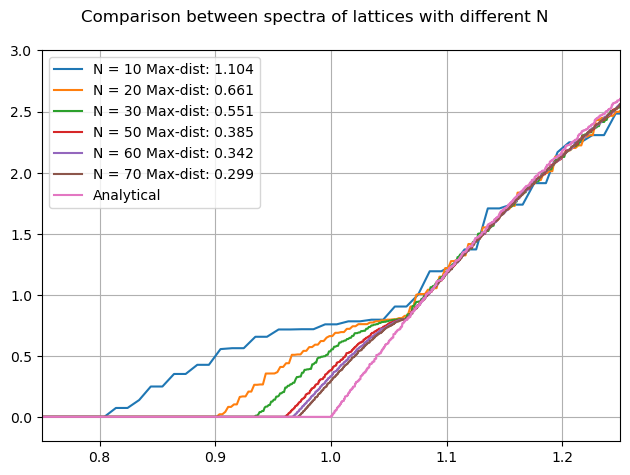

In [450]:
fig = plt.figure(tight_layout=1)

plt.suptitle("Comparison between spectra of lattices with different N")

for n in range(0,len(N),1):
    plt.plot(np.linspace(0,2,2*N[n]**2),arr_eig[n],label=f"N = {N[n]}"+f" Max-dist: {np.max(np.abs(arr_eig[n]-t(N[n]))):.3f}")

plt.plot(np.linspace(0,2,2*100**2),t(100),zorder=2,label="Analytical")

plt.xlim(0.75,1.25)
plt.ylim(-0.2,3)
plt.legend()
plt.grid()
#plt.savefig("comparison_OBC.png")
plt.show()

In [389]:
dist = []
for n in range(len(N)):
    dist.append(np.max(np.abs(arr_eig[n]-t(N[n]))))
dist = np.array(dist)

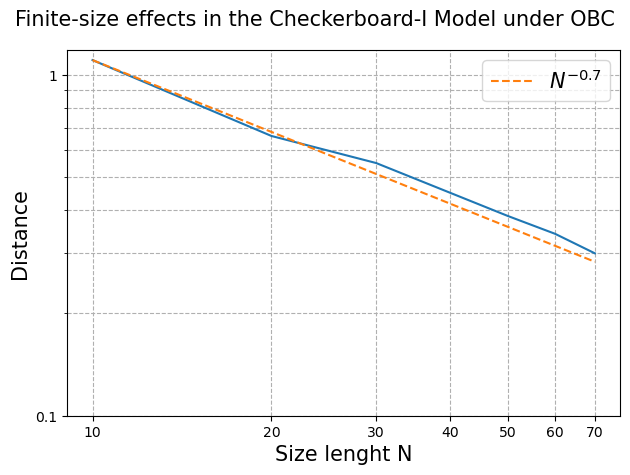

In [452]:
fig = plt.figure(tight_layout=1)

plt.suptitle("Finite-size effects in the Checkerboard-I Model under OBC",fontsize=15)
plt.plot(N,dist)
plt.plot(np.linspace(N[0],N[-1],100),dist[0]*np.power(N[0]/np.linspace(N[0],N[-1],100),0.7),ls="--",
        label=r"$N^{-0.7}$")


plt.xscale("log")
plt.yscale("log")
plt.xticks([10,20,30,40,50,60,70],[10,20,30,40,50,60,70])
plt.yticks(np.logspace(-1,0,2),[0.1,1])

plt.xlabel("Size lenght N",fontsize=15)
plt.ylabel("Distance",fontsize=15)

plt.grid(which="both",ls="--")
plt.legend(fontsize=15)
#plt.savefig("finite_size.png")
plt.show()